In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import OrderedDict

In [2]:
# Download the dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

mnist_data = datasets.MNIST(
    root="../data/raw/",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)
dataloader = DataLoader(mnist_data, batch_size=32, shuffle=True)

2.0%

100.0%


Extracting ../data/raw/MNIST/raw/train-images-idx3-ubyte.gz to ../data/raw/MNIST/raw



100.0%

Extracting ../data/raw/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/raw/MNIST/raw




65.6%

100.0%
100.0%


Extracting ../data/raw/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/raw/MNIST/raw

Extracting ../data/raw/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/raw/MNIST/raw



In [9]:
# Check the quantity of the dataset
total_data = 0

for data, label in dataloader:
    total_data+=data.shape[0]

print("Total number of dataset # {} ".format(total_data))
print("The shape of the dataset # {} ".format(data.shape))

Total number of dataset # 60000 
The shape of the dataset # torch.Size([32, 1, 28, 28]) 


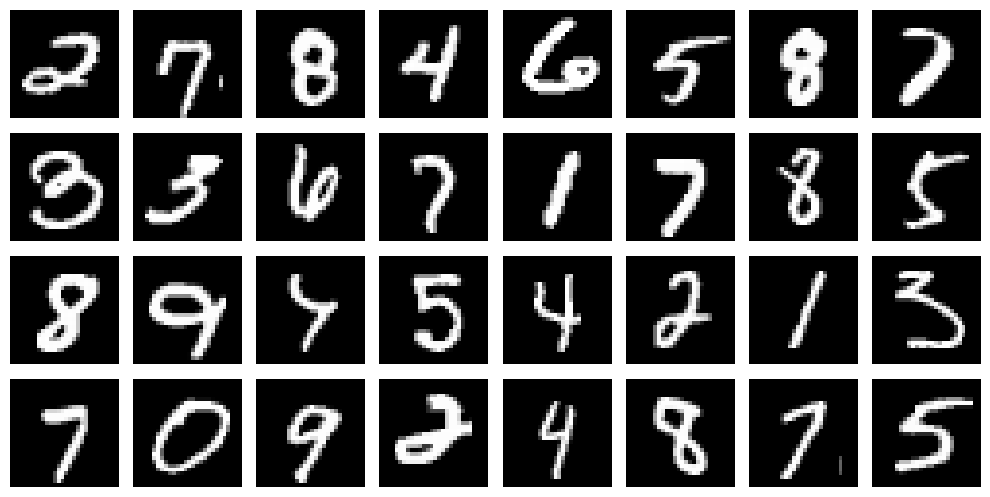

In [11]:
# Display the dataset

images, _ = next(iter(dataloader))
plt.figure(figsize=(10, 10))

for index, image in enumerate(images):
    plt.subplot(8, 8, index + 1)
    plt.imshow(image.view(28, 28), cmap="gray")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [38]:
def calculate_params(model):
    total_params = 0
    for layer, params in model.named_parameters():
        print("Layer # {} & params # {} ".format(layer, params.numel()))
        total_params += params.numel()

    return total_params

In [36]:
# Generator model
class Generator(nn.Module):
    def __init__(self, latent_space=100):
        self.latent_space = latent_space
        super(Generator, self).__init__()

        self.layers_config = [
            (self.latent_space, 256, 0.2),
            (256, 512, 0.2),
            (512, 1024, 0.2),
            (1024, 28 * 28),
        ]
        self.model = self.connected_layer(self.layers_config)

    def connected_layer(self, layers_config=None):
        layers = OrderedDict()

        if layers_config is not None:
            for index, (in_features, out_features, negative_slope) in enumerate(
                layers_config[:-1]
            ):
                layers["{}_layer".format(index)] = nn.Linear(
                    in_features=in_features, out_features=out_features
                )
                layers["{}_activation".format(index)] = nn.LeakyReLU(
                    negative_slope=negative_slope
                )

            (in_features, out_features) = layers_config[-1]
            layers["out_layer"] = nn.Linear(
                in_features=in_features, out_features=out_features
            )

            return nn.Sequential(layers)

        else:
            raise Exception("Layers is not defined in the Geneator".capitalize())

    def forward(self, x):
        if x is not None:
            x = self.model(x)
        else:
            raise Exception("Input is not defined in the Genearator".capitalize())
        return x.reshape(-1, 1, 28, 28)

In [41]:
# Critic Model

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.layers_config = [
            (28*28, 1024, 0.2),
            (1024, 512, 0.2),
            (512, 256, 0.2),
            (256, 1)
        ]
        self.model = self.connected_layer(self.layers_config)
    def connected_layer(self, layers_config = None):
        layers = OrderedDict()
        
        if layers_config is not None:
            for index, (in_features, out_features, negative_slope) in enumerate(layers_config[:-1]):
                layers["{}_layer".format(index)] = nn.Linear(
                    in_features = in_features, out_features = out_features)
                layers["{}_activation".format(index)] = nn.LeakyReLU(
                    negative_slope = negative_slope)
            
            (in_features, out_features) = layers_config[-1]
            layers["out_layer"] = nn.Linear(
                in_features = in_features, out_features = out_features)
            
            return nn.Sequential(layers)
        
        else:
            raise Exception("Layers is not defined in the Critic".capitalize())
    
    def forward(self, x):
        if x is not None:
            x = x.reshape(-1, 28*28)
            x = self.model(x)
        else:
            raise Exception("Input is not defined in the Critic".capitalize())
        return x

In [42]:
# Call the Generator
if __name__ == "__main__":
    generator = Generator()
    print(generator)

Generator(
  (model): Sequential(
    (0_layer): Linear(in_features=100, out_features=256, bias=True)
    (0_activation): LeakyReLU(negative_slope=0.2)
    (1_layer): Linear(in_features=256, out_features=512, bias=True)
    (1_activation): LeakyReLU(negative_slope=0.2)
    (2_layer): Linear(in_features=512, out_features=1024, bias=True)
    (2_activation): LeakyReLU(negative_slope=0.2)
    (out_layer): Linear(in_features=1024, out_features=784, bias=True)
  )
)


In [43]:
# Call the Critic
if __name__ == '__main__':
    critic = Critic()
    print(critic)

Critic(
  (model): Sequential(
    (0_layer): Linear(in_features=784, out_features=1024, bias=True)
    (0_activation): LeakyReLU(negative_slope=0.2)
    (1_layer): Linear(in_features=1024, out_features=512, bias=True)
    (1_activation): LeakyReLU(negative_slope=0.2)
    (2_layer): Linear(in_features=512, out_features=256, bias=True)
    (2_activation): LeakyReLU(negative_slope=0.2)
    (out_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [44]:
# Total parameters of the Critic
print("\nTotal parameters of the Generator: {}".format(calculate_params(critic)).upper())

Layer # model.0_layer.weight & params # 802816 
Layer # model.0_layer.bias & params # 1024 
Layer # model.1_layer.weight & params # 524288 
Layer # model.1_layer.bias & params # 512 
Layer # model.2_layer.weight & params # 131072 
Layer # model.2_layer.bias & params # 256 
Layer # model.out_layer.weight & params # 256 
Layer # model.out_layer.bias & params # 1 

TOTAL PARAMETERS OF THE GENERATOR: 1460225


In [45]:
# Check it works or not

noise_data = torch.randn(64, 100)
generator(noise_data).shape

torch.Size([64, 1, 28, 28])

In [46]:
# Total parameters of the Critic
print("\nTotal parameters of the Critic: {}".format(calculate_params(critic)).upper())

Layer # model.0_layer.weight & params # 802816 
Layer # model.0_layer.bias & params # 1024 
Layer # model.1_layer.weight & params # 524288 
Layer # model.1_layer.bias & params # 512 
Layer # model.2_layer.weight & params # 131072 
Layer # model.2_layer.bias & params # 256 
Layer # model.out_layer.weight & params # 256 
Layer # model.out_layer.bias & params # 1 

TOTAL PARAMETERS OF THE CRITIC: 1460225


In [47]:
# Check it works or not
dataset = torch.randn(64, 1, 28, 28)
critic(dataset).shape

torch.Size([64, 1])